In [6]:
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus
import random
import matplotlib.pyplot as plt

In [7]:
# Create a problem variable:
prob = LpProblem("Maximize_the_profit_Z", LpMaximize)

# Create problem variables:
x = LpVariable("x", lowBound=0, upBound=None) # x>=0
y = LpVariable("y", lowBound=0, upBound=None) # y>=0


# The objective function and constraints are added using the += operator to our model.
# Objective function Z
prob += 4*x + 3*y, "Profit"

# Constraints
prob += 2*x + y <= 20
prob += x + y <= 12

In [8]:
prob

Maximize_the_profit_Z:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: 2 x + y <= 20

_C2: x + y <= 12

VARIABLES
x Continuous
y Continuous

In [9]:
# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal production amount of x and y
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal profit
print("Total profit is: ", value(prob.objective))

Status: Optimal
x = 8.0
y = 4.0
Total profit is:  44.0


Plecakowy

In [10]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem(name="Knapsack_Problem", sense=LpMaximize)

# The 3 binary variables that can only take values of 0 or 1
x1 = LpVariable(name="Item1", cat='Binary')
x2 = LpVariable(name="Item2", cat='Binary')
x3 = LpVariable(name="Item3", cat='Binary')

# The objective function is added to 'prob'
prob += lpSum([50*x1, 100*x2, 120*x3]), "Total Value of Items in Knapsack"

# Constraint
prob += lpSum([10*x1, 20*x2, 30*x3]) <= 50, "Total Weight of Items in Knapsack"

# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal solution
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal total value
print("Total value of items in knapsack is: ", value(prob.objective))

Status: Optimal
Item1 = 0.0
Item2 = 1.0
Item3 = 1.0
Total value of items in knapsack is:  220.0


Binary Variables as switches:


In [11]:
prob = LpProblem(name="Switch_Problem", sense=LpMaximize)

# The variables are created
x = LpVariable(name="x", lowBound=0,upBound=8)
y = LpVariable(name="y", lowBound=0)
b1 = LpVariable(name="b1", cat='Binary')
b2 = LpVariable(name="b2", cat='Binary')
b3 = LpVariable(name="b3", cat='Binary')

# The objective function is added to 'prob' first
prob += lpSum([b1,b2,b3]), "Total Value"


M = 1000  # A very large number
eps = 0.00001# A very small number
prob += lpSum([x, y]) + M*(1-b1)>= 50 , "Weight constraint when b1 is 1"
prob += lpSum([x, 2*y]) + M*b1 <= 100 , "Weight constraint when b1 is 0"
prob += lpSum([3*x, 2*y]) + M*(1-b2)>= 50 , "Weight constraint when b2 is 1"
# It is not possible to model sharp inequalities `>` or `<` in solver,
# in order to model them a small epsilon value is added artificially to the non-sharp equations.
prob += lpSum([-x, 5*y]) + M*b3 >= 75+eps , "Weight constraint when b3 is 0"

# Solve the problem
prob.solve()
print("Status:", LpStatus[prob.status])

# Print the optimal solution
for v in prob.variables():
    print(v.name, "=", v.varValue)

# Print the optimal total value
print("Total value is: ", value(prob.objective))


Status: Optimal
b1 = 0.0
b2 = 1.0
b3 = 1.0
x = 8.0
y = 13.0
Total value is:  2.0


Uta - basic:


In [12]:
# Define criteria values
criterion1_values = [0, 25, 50, 75, 100]
criterion2_values = ["Bad", "Poor", "Neutral", "Good", "Excellent"]

# Create LP problem
prob = LpProblem("Simplified_UTA_Method", LpMaximize)

# Create decision variables for criteria
criterion1_vars = {val: LpVariable(f"criterion1_{val}", lowBound=0, upBound=1) for val in criterion1_values}
criterion2_vars = {val: LpVariable(f"criterion2_{val}", lowBound=0, upBound=1) for val in criterion2_values}

# Monotonicity constraints
for i in range(len(criterion1_values) - 1):
    prob += criterion1_vars[criterion1_values[i]] <= criterion1_vars[criterion1_values[i + 1]], f"Monotonicity_C1_{i}"
for i in range(len(criterion2_values) - 1):
    prob += criterion2_vars[criterion2_values[i]] <= criterion2_vars[criterion2_values[i + 1]], f"Monotonicity_C2_{i}"

# Normalization constraints
prob += criterion1_vars[0] == 0, "Normalize_C1_Lowest"
prob += criterion2_vars["Bad"] == 0, "Normalize_C2_Lowest"
prob += criterion1_vars[100] + criterion2_vars["Excellent"] == 1, "Normalize_Criteria_Sum"

# Weight constraints (not part of UTA but additional constraint)
prob += criterion1_vars[100] <= 0.75, "Weight_C1_Limit"
prob += criterion2_vars["Excellent"] <= 0.75, "Weight_C2_Limit"

# Define alternatives with random evaluations
alternatives = {
    f"Alternative{i+1}": {
        "C1": random.choice(criterion1_values),
        "C2": random.choice(criterion2_values)
    }
    for i in range(4)
}

# Create utility variables and constraints
alternative_utilities = {}
for name, evals in alternatives.items():
    utility_var = LpVariable(f"{name}_Utility", lowBound=0)
    alternative_utilities[name] = utility_var

    # Sum of selected criteria variables defines utility
    prob += utility_var == lpSum([criterion1_vars[evals["C1"]], criterion2_vars[evals["C2"]]]), f"Utility_{name}"

# Preference constraints provided by the decision maker
epsilon = 0.01 # Small value to ensure strict preference
prob += alternative_utilities["Alternative1"] >= alternative_utilities["Alternative2"] + epsilon, "Pref_A1_A2"
prob += alternative_utilities["Alternative1"] >= alternative_utilities["Alternative3"] + epsilon, "Pref_A1_A3"
prob += alternative_utilities["Alternative2"] >= alternative_utilities["Alternative4"] + epsilon, "Pref_A2_A4"

# No specific objective function; checking feasibility
# You need to write your own objective function depending on the variant of the UTA method.

prob += 0 # Placeholder objective function

# Solve the problem
prob.solve()

# Print results
print(f"Status: {LpStatus[prob.status]}")
print("\nOptimal Solution:")
for var in prob.variables():
    print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))
# In the results below, there is  __dummy = None which is a placeholder for the objective function.

Status: Infeasible

Optimal Solution:
Alternative1_Utility = 1.01
Alternative2_Utility = 1.0
Alternative3_Utility = 1.0
Alternative4_Utility = 0.76
__dummy = None
criterion1_0 = 0.0
criterion1_100 = 0.25
criterion1_25 = 0.25
criterion1_50 = 0.25
criterion1_75 = 0.25
criterion2_Bad = 0.0
criterion2_Excellent = 0.75
criterion2_Good = 0.75
criterion2_Neutral = 0.75
criterion2_Poor = 0.76

Objective value: None


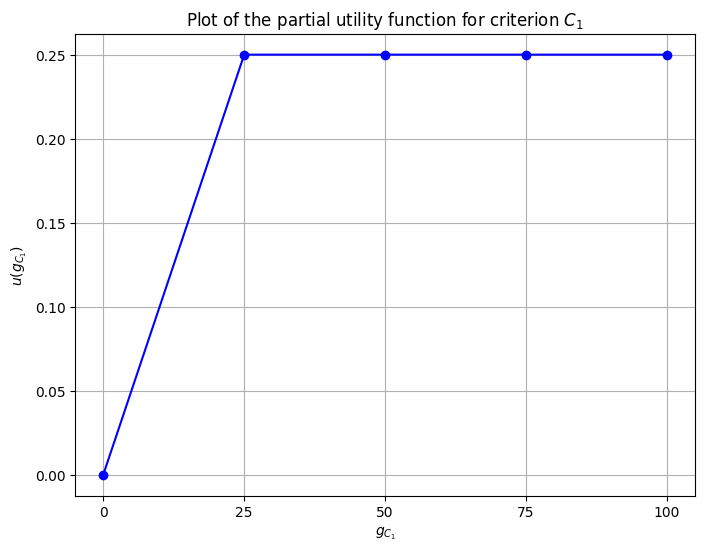

In [13]:
# This example demonstrates how to plot the partial utility function for criterion 1
solver_values = [value(criterion1_vars[val]) for val in criterion1_values]

plt.figure(figsize=(8, 6))
plt.plot(criterion1_values, solver_values, marker='o', linestyle='-', color='b', label='$u(g_{C_1})$')
plt.xlabel('$g_{C_1}$')
plt.ylabel('$u(g_{C_1})$')
plt.title('Plot of the partial utility function for criterion $C_1$')
plt.xticks(criterion1_values)
plt.grid(True)
plt.show()
